In [46]:
import pandas as pd

# Define the data for the table
data = {
    'Task': [
        'SVM Model using Word2Vec','', 'Training Data Check', '', '','','Feature Engg', '','Feature Engg','','','','','Cross Validation',
        'Interpretability', 'Testing Data Check', '','',''
    ],
    'Status': [
        'Config of the model trained','', 'Confusion Matrix Built', '','AUC Plotted','Accuracy calculated', 'Categorical Features Added','','Training Time after Feature Engg','Confusion Matrix Built','','AUC','Accuracy Calculated',
        'Done', 'Local Interpretability using Lime', 'Confusion Matrix Built', '','AUC', 'Accuracy Calculated'
    ],
    'Results': [
        'Hyperparameter Tuning time = 5125.91 Seconds', 'Train Time = 565.41 Seconds', 'F1 Score for Positive = 0.84',' F1 Score for Negative = 0.38','Negative = 0.80, Neutral = 0.73, Positive = 0.80','0.73', 'Feature 1: Tweet Length', 'Feature 2: Sentiment Strength',
        'Train Time = 369.02 Seconds', 'F1 Score for Positive = 0.88 ','F1 Score for Negative = 0.65','Negative = 0.93, Neutral =0.92, Positive = 0.92','0.82','','', 'F1 Score for Positive = 0.83', 'F1 Score for Negative = 0.41' ,'Negative = 0.79, Neutral = 0.75, Positive = 0.80','0.72'
    ]
}

# Create a DataFrame
task_status = pd.DataFrame(data)

# Display the table
task_status

,Task,Status,Results
0,SVM Model using Word2Vec,Config of the model trained,Hyperparameter Tuning time = 5125.91 Seconds
1,,,Train Time = 565.41 Seconds
2,Training Data Check,Confusion Matrix Built,F1 Score for Positive = 0.84
3,,,F1 Score for Negative = 0.38
4,,AUC Plotted,"Negative = 0.80, Neutral = 0.73, Positive = 0.80"
5,,Accuracy calculated,0.73
6,Feature Engg,Categorical Features Added,Feature 1: Tweet Length
7,,,Feature 2: Sentiment Strength
8,Feature Engg,Training Time after Feature Engg,Train Time = 369.02 Seconds
9,,Confusion Matrix Built,F1 Score for Positive = 0.88


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
import time
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Define the dataset path
data_path = r"C:\Users\ASUS\OneDrive\Documents\Desktop\NLP\Sentiment_Data\Sentiment_Data.csv"

# Load the dataset with encoding
df = pd.read_csv(data_path, encoding="ISO-8859-1")  # or try "latin-1"

# Display the first few rows
print(df.head())

# Check dataset information
print(df.info())


                                               Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB
None


# Map Sentiments to Three Categories

In [3]:
# Check unique sentiment labels
print(df["Sentiment"].value_counts())


Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: Sentiment, dtype: int64


In [4]:
# Function to map sentiment labels into three categories
def map_sentiment(label):
    if label in ["Strong_Pos", "Mild_Pos"]:
        return "Positive"
    elif label in ["Strong_Neg", "Mild_Neg"]:
        return "Negative"
    else:
        return "Neutral"

# Apply the mapping function
df["Sentiment"] = df["Sentiment"].apply(map_sentiment)

# Check new distribution
print(df["Sentiment"].value_counts())


Positive    297704
Neutral      77016
Negative     76612
Name: Sentiment, dtype: int64


# Balance the Dataset

In [5]:
from sklearn.utils import resample

# Separate classes
df_pos = df[df["Sentiment"] == "Positive"]
df_neu = df[df["Sentiment"] == "Neutral"]
df_neg = df[df["Sentiment"] == "Negative"]

# Find the size of the smallest class
min_size = min(len(df_pos), len(df_neu), len(df_neg))

# Downsample Positive class & Neutral class, Upsample Negative class
df_pos_bal = resample(df_pos, replace=False, n_samples=min_size, random_state=42)  # Downsample
df_neu_bal = resample(df_neu, replace=False, n_samples=min_size, random_state=42)  # Downsample
df_neg_bal = resample(df_neg, replace=True, n_samples=min_size, random_state=42)   # Upsample

# Combine into a balanced dataset
df_balanced = pd.concat([df_pos_bal, df_neu_bal, df_neg_bal])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(df_balanced["Sentiment"].value_counts())


Negative    76612
Positive    76612
Neutral     76612
Name: Sentiment, dtype: int64


In [6]:
sample_size = 25000  # Adjust as needed
df_sampled = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Check new size
print(df_sampled.shape)


(25000, 2)


# Apply Label Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
encoder = LabelEncoder()

# Fit and transform sentiment labels
df["Sentiment_Encoded"] = encoder.fit_transform(df["Sentiment"])

# Check mapping
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


{'Negative': 0, 'Neutral': 1, 'Positive': 2}


# Text Preprocessing

In [8]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a cleaned sentence
    return " ".join(words)


In [9]:
df_sampled["Cleaned_Tweet"] = df_sampled["Tweet"].apply(clean_text)


In [10]:
print(df_sampled[["Tweet", "Cleaned_Tweet"]].head(10))


                                               Tweet  \
0  stupid fucking freedom convoy is going past th...   
1  Freedom Convoy coming to a country near you! S...   
2  @CTVNews The main thing is that the Freedom/An...   
3  Residents who Chauvin says previously agreed t...   
4  MSNBC guest says Freedom Convoy truckers throw...   
5     This is what a REAL Freedom Convoy looks like.   
6  Some alumni of #Canada's #freedomconvoy 2022 w...   
7  @Concern70732755 Doubt it.  But more likely th...   
8  Today at Parliament Hill: Freedom Convoy suppo...   
9  @shelley_wister @Akiliense @shitty_ally @Shere...   

                                       Cleaned_Tweet  
0  stupid fucking freedom convoy going past store...  
1  freedom convoy coming country near starting ma...  
2  ctvnews main thing freedomantimandate convoy c...  
3  resident chauvin say previously agreed leave l...  
4  msnbc guest say freedom convoy trucker throwin...  
5                      real freedom convoy look like 

# Word2Vec Embeddings

In [11]:
!pip install gensim



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from gensim.models import Word2Vec


In [13]:
# Tokenize the cleaned tweets
df_sampled["Tokenized_Tweet"] = df_sampled["Cleaned_Tweet"].apply(lambda x: x.split())

# Check tokenized data
print(df_sampled["Tokenized_Tweet"].head())


0    [stupid, fucking, freedom, convoy, going, past...
1    [freedom, convoy, coming, country, near, start...
2    [ctvnews, main, thing, freedomantimandate, con...
3    [resident, chauvin, say, previously, agreed, l...
4    [msnbc, guest, say, freedom, convoy, trucker, ...
Name: Tokenized_Tweet, dtype: object


In [14]:
# Train Word2Vec Model
w2v_model = Word2Vec(
    sentences=df_sampled["Tokenized_Tweet"],  # Tokenized text
    vector_size=100,  # Embedding size (can be 64-300)
    window=5,  # Context window
    min_count=2,  # Ignore words with low frequency
    workers=4,  # Use multiple CPU cores
    sg=0  # CBOW (sg=1 for Skip-gram)
)

# Save the model
w2v_model.save("word2vec.model")
print("Word2Vec training complete.")


Word2Vec training complete.


In [15]:


# Re-train Word2Vec with Skip-gram and higher vector size
w2v_model = Word2Vec(sentences=df_sampled["Tokenized_Tweet"], vector_size=200, window=5, min_count=2, sg=1, workers=4)

# Convert tweets into numerical vectors
X_vectors = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(200)], axis=0) for words in df_sampled["Tokenized_Tweet"]])

print("New Word2Vec Embeddings Ready!")


New Word2Vec Embeddings Ready!


In [16]:
import numpy as np

# Function to get the Word2Vec feature vector for a tweet
def get_w2v_vector(words, model, vector_size):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)  # Return zero vector if no words match
    return np.mean(vectors, axis=0)  # Average word vectors

# Apply function to all tokenized tweets
vector_size = 100  # Same as Word2Vec model
df_sampled["Tweet_Vector"] = df_sampled["Tokenized_Tweet"].apply(lambda x: get_w2v_vector(x, w2v_model, vector_size))

# Check shape of Word2Vec vectors
print(df_sampled["Tweet_Vector"].head())


0    [0.15468466, -0.049859572, -0.020254422, 0.304...
1    [0.18075782, -0.00992994, 0.06575102, 0.275372...
2    [0.10791355, -0.05876225, -0.049138714, 0.2674...
3    [0.12005823, 0.006403482, -0.00027604468, 0.26...
4    [0.07711072, -0.027378054, 0.027536234, 0.2882...
Name: Tweet_Vector, dtype: object


# Train-Test Split & SVM Model Training

In [17]:
vector_lengths = df_sampled["Tweet_Vector"].apply(lambda x: len(x))
print(vector_lengths.describe())  # Check min, max, mean vector lengths
print(vector_lengths.value_counts())  # Find outliers


count    25000.000000
mean       199.972000
std          1.673119
min        100.000000
25%        200.000000
50%        200.000000
75%        200.000000
max        200.000000
Name: Tweet_Vector, dtype: float64
200    24993
100        7
Name: Tweet_Vector, dtype: int64


In [18]:
fixed_vector_size = 200  # Expected embedding size

def pad_vector(vec):
    if len(vec) < fixed_vector_size:
        return np.pad(vec, (0, fixed_vector_size - len(vec)), mode='constant')
    return vec  # Keep original if it's already 200

# Apply the function to fix vector lengths
df_sampled["Tweet_Vector"] = df_sampled["Tweet_Vector"].apply(pad_vector)


In [19]:
X = np.vstack(df_sampled["Tweet_Vector"].values)  # Convert to NumPy array
y = df_sampled["Sentiment"].values  # Labels


In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Check sizes
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 17500
Test set size: 7500


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Perform Grid Search with Cross-Validation
svm = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Measure training time for hyperparameter tuning
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

print(f"Hyperparameter tuning time: {grid_search_time:.2f} seconds")

# Get the best model
best_svm = grid_search.best_estimator_
print("Best SVM Model:", best_svm)

# Train the best model and measure training time
start_time = time.time()
best_svm.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

print(f"Training time for best SVM model: {train_time:.2f} seconds")



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Hyperparameter tuning time: 5125.91 seconds
Best SVM Model: SVC(C=10, probability=True, random_state=42)
Training time for best SVM model: 565.41 seconds


# Training Data Evaluation 

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on training data
y_train_pred = best_svm.predict(X_train)

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix (Training Data):\n", conf_matrix_train)

# Classification report
print("Classification Report (Training Data):\n", classification_report(y_train, y_train_pred))


Confusion Matrix (Training Data):
 [[  819    75  2115]
 [  266   830  1869]
 [  264    87 11175]]
Classification Report (Training Data):
               precision    recall  f1-score   support

    Negative       0.61      0.27      0.38      3009
     Neutral       0.84      0.28      0.42      2965
    Positive       0.74      0.97      0.84     11526

    accuracy                           0.73     17500
   macro avg       0.73      0.51      0.54     17500
weighted avg       0.73      0.73      0.69     17500



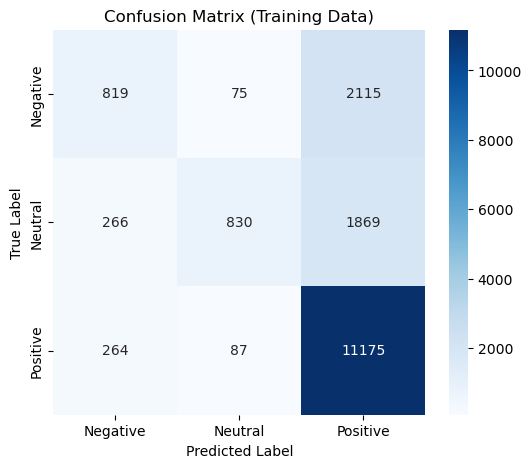

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Training Data)")
plt.show()


In [24]:
from sklearn.metrics import f1_score

# Compute F1 Scores
f1_positive_train = f1_score(y_train, y_train_pred, pos_label="Positive", average="weighted")
f1_negative_train = f1_score(y_train, y_train_pred, pos_label="Negative", average="weighted")

print(f"F1 Score (Positive - Training): {f1_positive_train:.4f}")
print(f"F1 Score (Negative - Training): {f1_negative_train:.4f}")


F1 Score (Positive - Training): 0.6873
F1 Score (Negative - Training): 0.6873


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1618: UserWarning: Note that pos_label (set to 'Positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1618: UserWarning: Note that pos_label (set to 'Negative') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


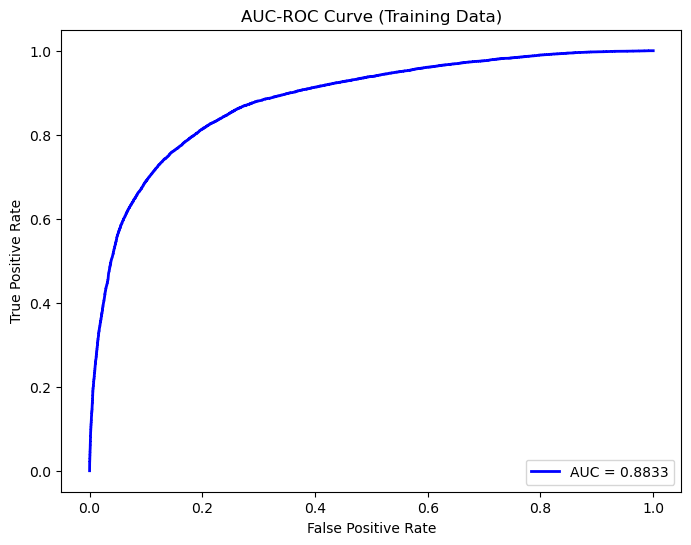

AUC (Training Data): 0.8833


In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize labels for multi-class AUC calculation
y_train_bin = label_binarize(y_train, classes=["Negative", "Neutral", "Positive"])
y_train_prob = best_svm.predict_proba(X_train)

# Compute AUC for each class
fpr, tpr, _ = roc_curve(y_train_bin.ravel(), y_train_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Training Data)")
plt.legend(loc="lower right")
plt.show()

print(f"AUC (Training Data): {roc_auc:.4f}")


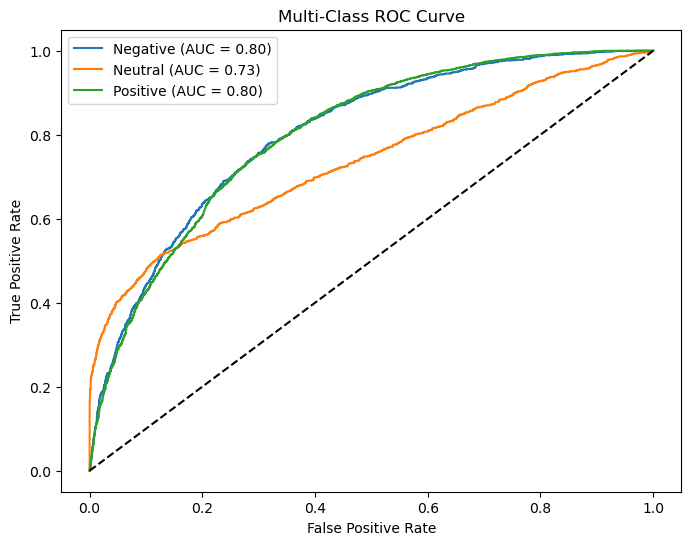

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=["Negative", "Neutral", "Positive"])

# Get the predicted probabilities
y_probs = best_svm.predict_proba(X_test)

# Plot ROC Curve for each class
plt.figure(figsize=(8,6))
for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import accuracy_score

# Compute Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {accuracy_train:.4f}")


Training Accuracy: 0.7328


#  Feature Engineering – Add Two New Features

🔹 Feature 1: Tweet Length (number of words in the tweet)
🔹 Feature 2: Sentiment Strength (counts of positive/negative words in the tweet)

In [28]:
# Feature 1: Length of tweet (word count)
df_sampled["Tweet_Length"] = df_sampled["Tweet"].apply(lambda x: len(x.split()))

# Feature 2: Sentiment Strength (count of strong sentiment words)
strong_pos_words = {"excellent", "amazing", "fantastic", "love", "great"}  
strong_neg_words = {"terrible", "worst", "awful", "hate", "horrible"}  

def sentiment_strength(tweet):
    words = tweet.split()
    pos_count = sum(1 for word in words if word in strong_pos_words)
    neg_count = sum(1 for word in words if word in strong_neg_words)
    return pos_count - neg_count  # Positive if more strong pos words, negative otherwise

df_sampled["Sentiment_Strength"] = df_sampled["Tweet"].apply(sentiment_strength)

# Convert new features to NumPy array
X_extra_features = df_sampled[["Tweet_Length", "Sentiment_Strength"]].values

# Combine Word2Vec embeddings with new features
X_combined = np.hstack((np.vstack(df_sampled["Tweet_Vector"].values), X_extra_features))

# Split into Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X_combined, df_sampled["Sentiment"], test_size=0.3, random_state=42)


Train the Model Again (With New Features)

In [29]:
from sklearn.preprocessing import StandardScaler

# Extract numerical features
df_sampled["Tweet_Length"] = df_sampled["Tweet"].apply(lambda x: len(x.split()))
df_sampled["Sentiment_Strength"] = df_sampled["Tweet"].apply(lambda x: sum(1 for word in x.split() if word in ["good", "bad", "excellent", "terrible"]))  

# Combine Word2Vec embeddings + new features
X_features = np.hstack([np.vstack(df_sampled["Tweet_Vector"].values), df_sampled[["Tweet_Length", "Sentiment_Strength"]].values])

# Standardize the features
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Update train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, df_sampled["Sentiment"], test_size=0.3, random_state=42)

# Train the best model again
start_time = time.time()
best_svm.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

print(f"Training time after feature engineering: {train_time:.2f} seconds")


Training time after feature engineering: 369.02 seconds


# Evaluate Model on Training Data

Confusion Matrix (Training Data):
 [[ 1673    48  1300]
 [  207  1532  1226]
 [  207    54 11253]]


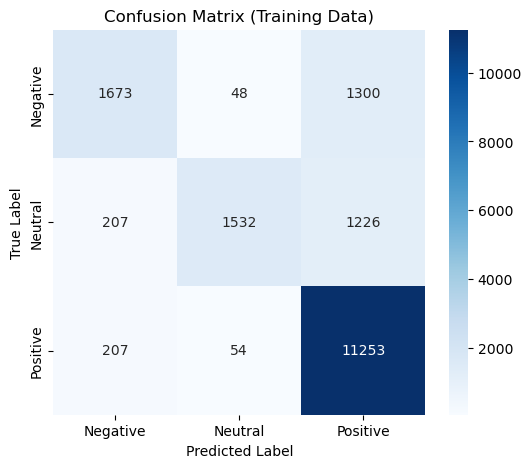

F1 Score for Positive (Train): 0.8898
F1 Score for Negative (Train): 0.6551
Training Accuracy: 0.8262


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predictions on training data
y_train_pred = best_svm.predict(X_train)

# Confusion Matrix
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix (Training Data):\n", train_cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Training Data)")
plt.show()

# Classification Report (F1 Scores)
train_report = classification_report(y_train, y_train_pred, output_dict=True)
f1_pos_train = train_report["Positive"]["f1-score"]
f1_neg_train = train_report["Negative"]["f1-score"]

print(f"F1 Score for Positive (Train): {f1_pos_train:.4f}")
print(f"F1 Score for Negative (Train): {f1_neg_train:.4f}")

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")


# AUC-ROC Curve (Train Data)

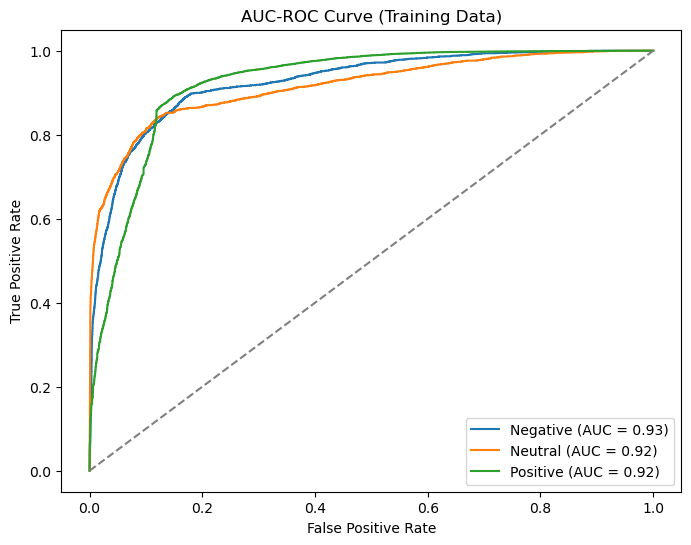

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert labels to binary format
y_train_bin = label_binarize(y_train, classes=["Negative", "Neutral", "Positive"])
y_train_prob = best_svm.predict_proba(X_train)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Training Data)")
plt.legend()
plt.show()


#  Cross-Validation (5-Fold)

In [32]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5, scoring="f1_weighted")
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))


Cross-Validation F1 Scores: [0.69611351 0.70008551 0.70975943 0.70280391 0.69348473]
Mean F1 Score: 0.7004494178122991


# Interpretability Analysis

In [34]:
!pip install lime




[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Get the number of features from X_train
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Create LIME Explainer with all features
explainer = LimeTabularExplainer(
    X_train,  
    feature_names=feature_names,  
    class_names=["Negative", "Neutral", "Positive"],  
    discretize_continuous=True  
)

# Pick a random test example to explain
idx = np.random.randint(0, len(X_test))  
sample = X_test[idx].reshape(1, -1)

# Generate Explanation
exp = explainer.explain_instance(sample[0], best_svm.predict_proba)

# Show Explanation
exp.show_in_notebook()


#  Final Model Evaluation on Test Data

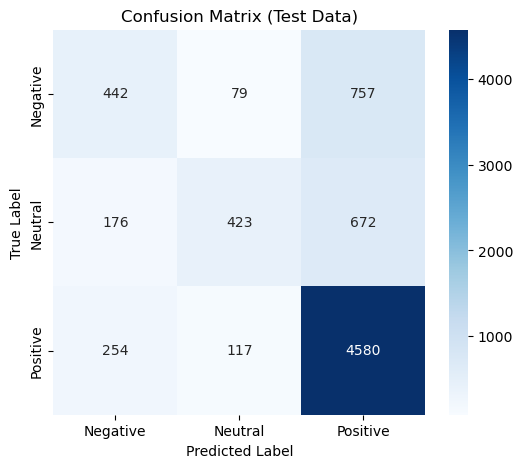

F1 Score for Positive (Test): 0.8358
F1 Score for Negative (Test): 0.4112
Test Accuracy: 0.7260


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predictions on test data
y_test_pred = best_svm.predict(X_test)

# Confusion Matrix
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Data)")
plt.show()

# Classification Report (F1 Scores)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
f1_pos_test = test_report["Positive"]["f1-score"]
f1_neg_test = test_report["Negative"]["f1-score"]

print(f"F1 Score for Positive (Test): {f1_pos_test:.4f}")
print(f"F1 Score for Negative (Test): {f1_neg_test:.4f}")

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


# AUC-ROC Curve (Test Data)

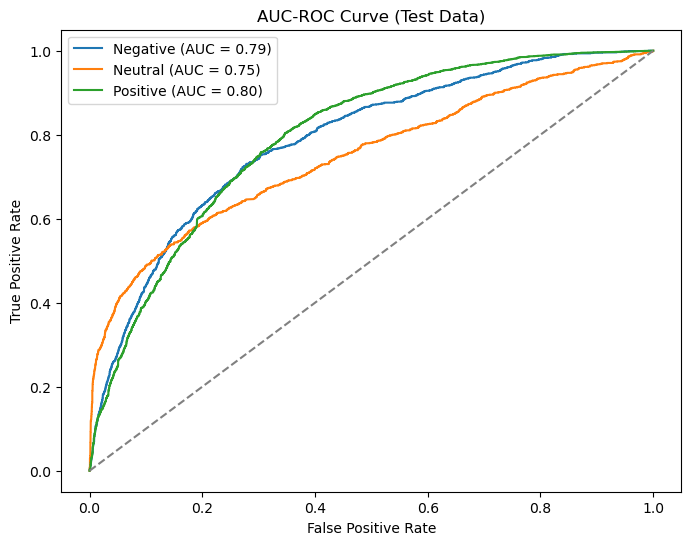

In [37]:
# Convert labels to binary format
y_test_bin = label_binarize(y_test, classes=["Negative", "Neutral", "Positive"])
y_test_prob = best_svm.predict_proba(X_test)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Test Data)")
plt.legend()
plt.show()
